In [1]:
import os
import plaidml.keras
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sys
import plaidml.keras
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using plaidml.keras.backend backend.


In [3]:
import keras

In [4]:
traininglabels_df = pd.read_csv("traininglabels.csv") 
testlabels_df = pd.read_csv("testlabels.csv")

In [5]:
traininglabels_df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [6]:
testlabels_df.head()

,image_id,has_oilpalm,score
0,img_049252017.jpg,0,1.0
1,img_048172017.jpg,1,1.0
2,img_103582017.jpg,0,1.0
3,img_067292017.jpg,0,0.6
4,img_090082017.jpg,0,1.0


In [7]:
ls -lrt

total 54991472
drwxr-xr-x@  2180 michael  staff        69760 Apr  3 19:51 leaderboard_holdout_data/
-rw-r--r--@     1 michael  staff     46258105 Apr  3 19:51 leaderboard_holdout_data.zip
-rw-r--r--@     1 michael  staff       137236 Apr  3 19:51 SampleSubmission.csv
-rw-r--r--@     1 michael  staff    332511021 Apr  3 19:51 train_images.zip
-rw-r--r--@     1 michael  staff       362925 Apr  3 19:51 traininglabels.csv
-rw-r--r--@     1 michael  staff       103892 Apr  3 19:51 testlabels.csv
-rw-r--r--@     1 michael  staff     94811591 Apr  3 19:51 leaderboard_test_data.zip
-rw-r--r--@     1 michael  staff       203918 Apr  3 19:51 solutionFile.csv
drwxr-xr-x@ 15246 michael  staff       487872 Apr  3 19:51 train_images/
drwxr-xr-x@  4358 michael  staff       139456 Apr  3 19:51 leaderboard_test_data/
-rw-r--r--      1 michael  staff    904320128 Apr  3 21:14 undersampled_images.npy
-rw-r--r--      1 michael  staff        15200 Apr  3 21:14 undersampled_labeles.npy
-rw-r--r--      1 mic

In [8]:
folder_train = 'train_images/'
folder_test = 'leaderboard_test_data/'

### No Oil Palm

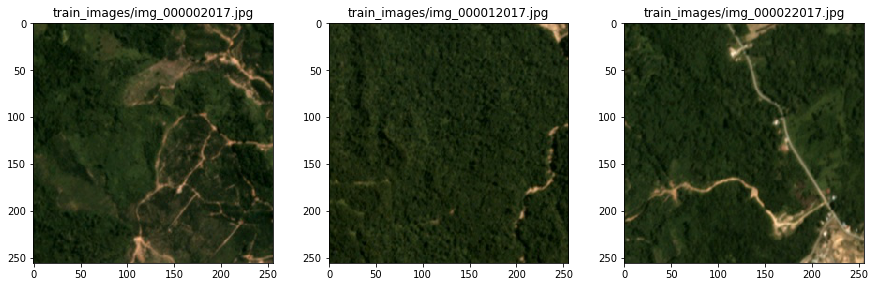

In [9]:
fig = plt.figure(figsize=(15,15))
for i in range(3):
    plt.subplot(331+ i)
    filename = folder_train + 'img_0000' + str(i) + '2017.jpg'
    image = imread(filename)
    plt.title(filename)
    plt.imshow(image)

plt.show()

This just looks like wilderness

### Oil Palm

In [10]:
oilpalm_img = list(traininglabels_df[traininglabels_df['has_oilpalm'] == 1][traininglabels_df['score'] == 1][:3]['image_id'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


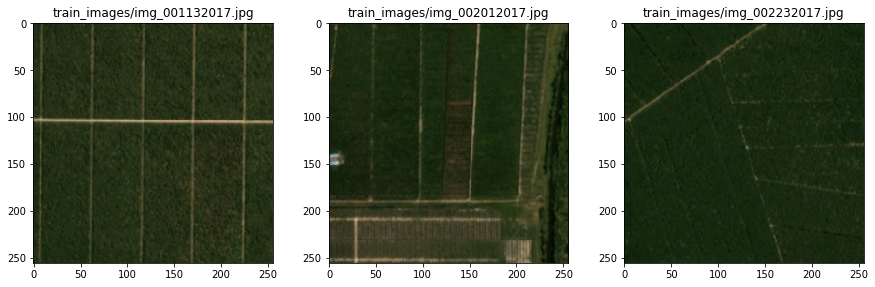

In [11]:
fig = plt.figure(figsize=(15,15))
for i in range(3):
    plt.subplot(331+ i)
    filename = folder_train+oilpalm_img[i]
    image = imread(filename)
    plt.title(filename)
    plt.imshow(image)

plt.show()

So, the images labeled with oil palm have lots inherent linear geometry: lines, rectangles

In [12]:
df_class0 = traininglabels_df[traininglabels_df['has_oilpalm'] == 0]
df_class1 = traininglabels_df[traininglabels_df['has_oilpalm'] == 1]
df_plot = pd.concat([df_class0, df_class1], axis=0)
df_class0.shape[0], df_class1.shape[0]

(14302, 942)

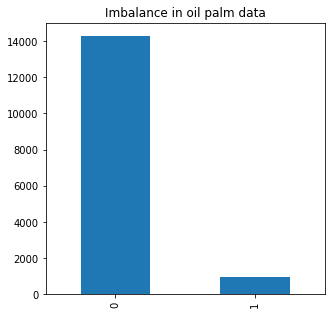

In [13]:
fig = plt.figure(figsize=(5,5))
df_plot['has_oilpalm'].value_counts().plot(kind='bar', title = 'Number of Images')
plt.title("Imbalance in oil palm data")
plt.show()

So there's about an order of magnitude more images with no oil palm than there are of images with oil palm.

### Undersampling

#### As a first approach, I can look at undersampling- removing all but the first 942 'not oil palm' images.  Let's try removing the images where has_oilpalm = 0 but the score is not 1.

In [14]:
df = traininglabels_df

In [15]:
df = df[df['has_oilpalm'] == 0][df['score'] == 1]
df.reset_index(drop=True, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [16]:
df.head()

,image_id,has_oilpalm,score
0,img_000012017.jpg,0,1.0
1,img_000022017.jpg,0,1.0
2,img_000072017.jpg,0,1.0
3,img_000082017.jpg,0,1.0
4,img_000092017.jpg,0,1.0


#### Then reassign to df_class0 and df_class1 to see how the distribution has changed

In [17]:
df_class0 = df[df['has_oilpalm'] == 0]
df_class1 = traininglabels_df[traininglabels_df['has_oilpalm'] == 1]
df_plot = pd.concat([df_class0, df_class1], axis=0)
df_class0.shape[0], df_class1.shape[0]

(11955, 942)

In [18]:
df_class0.head()

,image_id,has_oilpalm,score
0,img_000012017.jpg,0,1.0
1,img_000022017.jpg,0,1.0
2,img_000072017.jpg,0,1.0
3,img_000082017.jpg,0,1.0
4,img_000092017.jpg,0,1.0


In [19]:
df_under = pd.concat([df_class0.iloc[:942], df_class1], axis=0)
df_under.reset_index(drop=True, inplace=True)
df_under.head()

,image_id,has_oilpalm,score
0,img_000012017.jpg,0,1.0
1,img_000022017.jpg,0,1.0
2,img_000072017.jpg,0,1.0
3,img_000082017.jpg,0,1.0
4,img_000092017.jpg,0,1.0


#### First has_oilpalm data appears at row 943

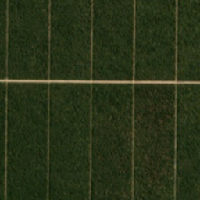

In [20]:
load_img(folder_train + df_under['image_id'][943], target_size=(200, 200))

#### First has_oilpalm = 0data appears at row 0

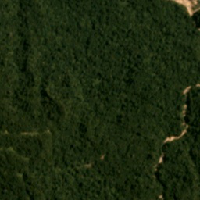

In [21]:
load_img(folder_train + df_under['image_id'][0], target_size=(200, 200))

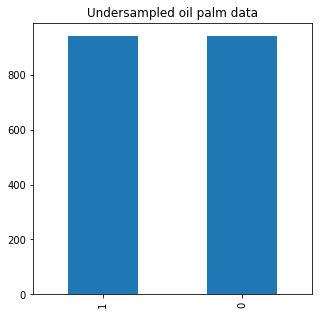

In [22]:
fig = plt.figure(figsize=(5,5))
df_under['has_oilpalm'].value_counts().plot(kind='bar', title = 'Number of Images')
plt.title("Undersampled oil palm data")
plt.show()

### Create image array

### Utitlity function that grabs the data I need and returns numpy arrays

In [23]:
def transformdata(df_in, name, trainortest):
    #reset the dataframe in case its discontinuous and randomize the data
    df_in.sample(frac=1).reset_index(drop=True, inplace=True)
    photo_list = []
    
    if(trainortest == 'train'):
        folder = folder_train
    elif(trainortest == 'test'):
        folder = folder_test
    else:
        return
    
    for i in range(df_in.shape[0]):
        #load image
        photo = load_img(folder + df_in['image_id'][i], target_size=(200, 200))
        #convert to np array and store
        photo_list.append(img_to_array(photo))
    
    #create the labels also
    label_list = df_in['has_oilpalm'].tolist()
    #convert to numpy array for the model
    photos = asarray(photo_list)
    labels = asarray(label_list)
    #save a copy so i can access the data later
    save(name +'_images.npy', photos)
    save(name +'_labeles.npy', labels)
    #print the shape of the image, label data
    print(photos.shape, labels.shape)
    return photos, labels

#### Undersampled Training Data

In [24]:
image_under_train, label_under_train = transformdata(df_under, 'undersampled_train', 'train')

(1884, 200, 200, 3) (1884,)


#### Test Data

In [25]:
image_test, label_test = transformdata(testlabels_df, 'test', 'test')

(4356, 200, 200, 3) (4356,)


### Modeling Undersampled Data

#### Lets use a randomforest classifier to get a baseline result:

In [26]:
import keras
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

#### Utitlity function that gives me classification relevant metrics

In [27]:
def GetMetrics(model, x_test, y_test, name):
    
    prediction = model.predict(x_test)
    y_pred = [1 if prediction[i][0]> .5 else 0 for i in range(len(prediction))]
    
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
    metrics['Accuracy'] = [accuracy_score(y_test, y_pred)]
    metrics['Precision'] = [precision_score(y_test, y_pred)]
    metrics['Recall'] = [recall_score(y_test, y_pred)]
    metrics['F1'] = [f1_score(y_test, y_pred)]
    metrics['ROC'] = [roc_auc_score(y_test, y_pred)]
    
    false_positive_rate, true_positive_rate, threshold1 = roc_curve(y_test, y_pred)
    
    fig = plt.figure(figsize=(5,5))
    plt.title('ROC Curve for ' + name)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    stats = metrics.sort_values('Accuracy', ascending = False)
    return stats

#### Visualize Model Training History:

In [28]:
def plothistory(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Build a CNN Model

In [29]:
def getCNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [30]:
cnn = getCNN()
cnn.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               20480128  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

In [31]:
history = cnn.fit(image_under_train, label_under_train, validation_data=(image_test, label_test), epochs=5, batch_size = 128)

Train on 1884 samples, validate on 4356 samples
Epoch 1/5
1884/1884 [==============================] - 39s 21ms/step - loss: 7.8897 - acc: 0.5032 - val_loss: 14.9286 - val_acc: 0.0636
Epoch 2/5
1884/1884 [==============================] - 35s 18ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 14.9286 - val_acc: 0.0636
Epoch 3/5
1884/1884 [==============================] - 34s 18ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 14.9286 - val_acc: 0.0636
Epoch 4/5
1884/1884 [==============================] - 34s 18ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 14.9286 - val_acc: 0.0636
Epoch 5/5
1884/1884 [==============================] - 34s 18ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 14.9286 - val_acc: 0.0636


#### GetMetrics tells me that my model is no better than flipping a dice.

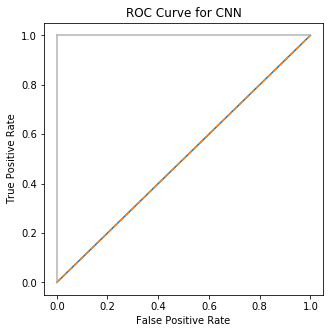

,Accuracy,Precision,Recall,F1,ROC
0,0.06359,0.06359,1.0,0.119577,0.5


In [32]:
GetMetrics(cnn, image_test, label_test, 'CNN')

#### In addition, the model accuracy/loss is constant for 5 epochs

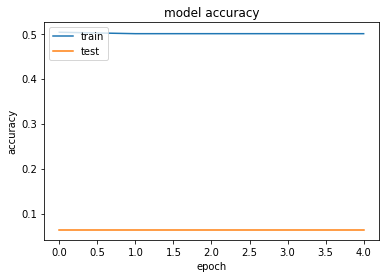

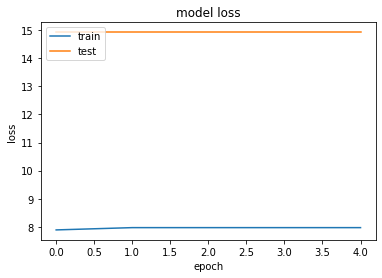

In [33]:
plothistory(history)

### Lets try using a pretrained model:

In [40]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

In [41]:
restnet = ResNet50(include_top = False, weights='imagenet', input_shape=(200, 200, 3))
#output = restnet.layers[-1].output
#output = Flatten()(output)

In [42]:
#restnet = Model(restnet.input, output=output)

In [43]:
for layer in restnet.layers:
    layer.trainable = False

In [44]:
restnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [62]:
def getResNet():
    model = Sequential()
    model.add(restnet)
    model.add(Dense(512, activation='relu', input_dim = (200, 200, 3)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [64]:
resnet = getResNet()
resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_27 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 75,231,617
Trainable params: 51,643,905
Non-trainable params: 23,587,712
_______________________________________________________

In [66]:
history = resnet.fit(image_under_train, label_under_train, validation_data=(image_test, label_test), epochs=10, batch_size = 128, verbose = False)

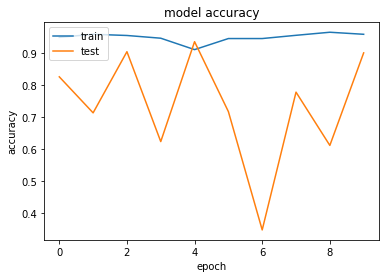

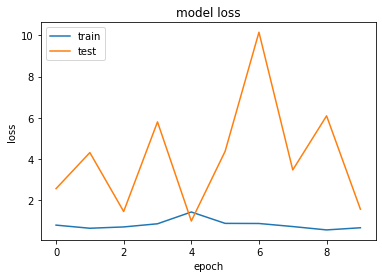

In [67]:
plothistory(history)

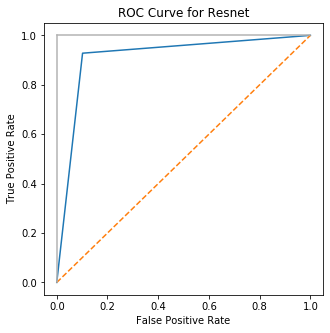

,Accuracy,Precision,Recall,F1,ROC
0,0.900138,0.38244,0.927798,0.541623,0.913029


In [68]:
GetMetrics(resnet, image_test, label_test, 'Resnet')

#### Undersampling with Restnet50 transfer model gets a pretty good result: with Area under the curve ROC ~ .91.  Accuracy is .90.  The issue is that the validation accuracy swings wildly during training.  I could fix this perhaps by having more data.  Since I'm undersampling my trainging data consists of about 1000 images, but validation test data consists of 4000.  Next thing to do is try oversampling or not changing sampling at all.

In [63]:
def getResNet2():
    restnet = ResNet50(include_top = False, weights='imagenet', input_shape=(200, 200, 3))
    for layer in restnet.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(restnet)
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [64]:
resnet2 = getResNet2()
resnet2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 128)         2359424   
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 128)         147584    
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1153      
Total params: 26,095,873
Trainable params: 2,508,161
Non-trainable params: 23,587,712
________________________________________________________

In [65]:
history = resnet2.fit(image_under_train, label_under_train, validation_data=(image_test, label_test), epochs=10, batch_size = 128)

Train on 1884 samples, validate on 4356 samples
Epoch 1/10
1884/1884 [==============================] - 134s 71ms/step - loss: 0.9293 - acc: 0.8190 - val_loss: 0.4067 - val_acc: 0.8579
Epoch 2/10
1884/1884 [==============================] - 74s 39ms/step - loss: 0.0837 - acc: 0.9687 - val_loss: 0.3434 - val_acc: 0.8786
Epoch 3/10
1884/1884 [==============================] - 66s 35ms/step - loss: 0.0333 - acc: 0.9873 - val_loss: 0.7866 - val_acc: 0.7532
Epoch 4/10
1884/1884 [==============================] - 65s 35ms/step - loss: 0.0166 - acc: 0.9936 - val_loss: 0.8305 - val_acc: 0.7562
Epoch 5/10
1884/1884 [==============================] - 65s 35ms/step - loss: 0.0095 - acc: 0.9984 - val_loss: 0.6661 - val_acc: 0.8221
Epoch 6/10
1884/1884 [==============================] - 67s 35ms/step - loss: 0.0049 - acc: 0.9984 - val_loss: 0.7708 - val_acc: 0.8039
Epoch 7/10
1884/1884 [==============================] - 67s 36ms/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.7117 - val_acc: 0.8189

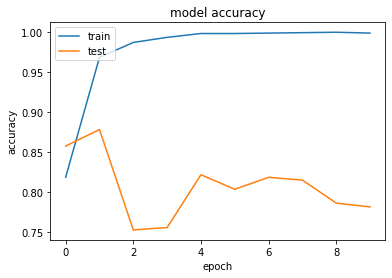

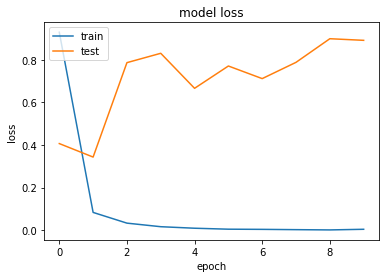

In [66]:
plothistory(history)

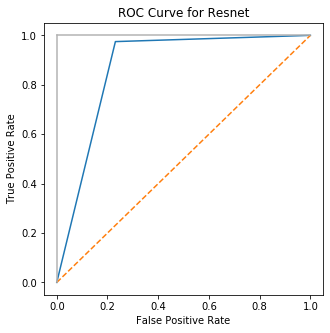

,Accuracy,Precision,Recall,F1,ROC
0,0.78191,0.222589,0.974729,0.362416,0.871773


In [67]:
GetMetrics(resnet2, image_test, label_test, 'Resnet')

#### Undersampling with resnet50 with weights fixed output to 2 layer CNN.  The training accuracy follows a curve that I expect but the validation accuracy still does cycle a bit during training.